In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time

In [2]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.show()
    #Create samples without bias
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = torch.zeros(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAll)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples

In [55]:

def evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, K = 3, is_euclidian = True):
    #We clone the data for better handling
    copy_data_training = torch.clone(data_training)
    #Create a column full of ones to append to the data training
    ones = torch.ones(data_training.shape[0], 1)
    #We append the column of ones
    distanced_data_training = torch.cat((copy_data_training, ones, ), 1)
    #print("-------Training data with distances not available yet--------------")
    #print(distanced_data_training)

    distance_matrix = build_distance_matrix_with_euclidean_distance(test_observation, data_training) if is_euclidian == True else build_distance_matrix_with_manhattann_distance(test_observation, data_training)

    distanced_data_training[:, 2].mul_(distance_matrix)

    #print("------------Training data With distances available....-------------")
    #print(distanced_data_training)
    
    
    #print("---------Distanced data training sorted....--------")
    # Sorts training points on the basis of distance
    sorted_values, sorted_index = torch.sort(distanced_data_training[:, 2]) 
    #print("---------Sorted values....--------")
    #print(sorted_values)
    #print("---------Sorted index....--------")
    #print(sorted_index)

    #Here we have k neighbors
    k_neighbors_values = sorted_values[:K] # selects k-nearest neighbors
    k_neighbors_index = sorted_index[:K] # selects k-nearest neighbors
    

    #Lets vote

    #print("---------K NEAREST NEIGHBORS....--------")
    #print(k_neighbors_values)
    #print(k_neighbors_index)

    #print("-----------Labels------------")
    k_labels = labels_training[k_neighbors_index]
    #print(k_labels)
    #Here we get the most common category of the K nearest neighbors
    t_estimated = torch.mode(k_labels, 0).values.item()
    return t_estimated

def build_distance_matrix_with_euclidean_distance(observation, SamplesAll):
    observation_matrix = observation.repeat(SamplesAll.shape[0],1)
    #print("Observation Matrixes :", observation_matrix)

    distances_matrix = SamplesAll - observation_matrix
    #print("Distances Matrixes :", distances_matrix)

    distances_matrix_sum = torch.sum(distances_matrix, dim=1)
    #print("Distances Matrixes SUM:", distances_matrix_sum)

    distances_matrix_powed = torch.pow(distances_matrix_sum, 2)
    #print("Distances Matrixes POWED:", distances_matrix_powed)

    distances_matrix_sqrt = torch.sqrt(distances_matrix_powed)
    #print("Distances Matrixes SQRT:", distances_matrix_sqrt)

    distances_matrix_final = np.round(distances_matrix_sqrt, 3)
    #print("Distances Matrixes FINAL:", distances_matrix_final)

    return distances_matrix_final

def build_distance_matrix_with_manhattann_distance(observation, SamplesAll):
    observation_matrix = observation.repeat(SamplesAll.shape[0],1)
    #print("Observation Matrixes :", observation_matrix)

    distances_matrix = SamplesAll - observation_matrix
    #print("Distances Matrixes :", distances_matrix)

    distances_matrix = torch.abs(distances_matrix)

    distances_matrix_sum = torch.sum(distances_matrix, dim=1)
    #print("Distances Matrixes SUM:", distances_matrix_sum)

    distances_matrix_final = np.round(distances_matrix_sum, 3)
    #print("Distances Matrixes FINAL:", distances_matrix_final)

    return distances_matrix_final
  
def evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, test_dataset, K = 7, is_euclidian = True):
    register = 0
    observation_estimates = torch.ones(data_training.shape[0], 1)
    for sample_point in test_dataset:
        observation_estimate = evaluate_k_nearest_neighbors_observation(data_training, labels_training, sample_point, K, is_euclidian)
        observation_estimates[register, 0].mul_(observation_estimate)
        register += 1
    return observation_estimates

def calculate_accuracy(test_estimations, test_labels):
    total_amount_samples = test_labels.shape[0]
    total_amount_right_estimations = (test_estimations == test_labels).sum()
    return (total_amount_right_estimations / total_amount_samples).item()

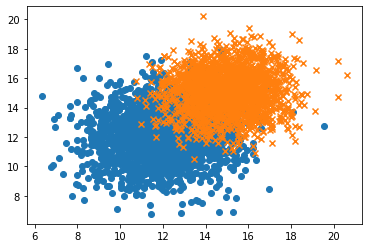

Testing KNN with K = 7 and Euclidean distance
Accuracy is: 0.9192500114440918
Time duration : 4.352615594863892
Testing KNN with K = 7 and Manhattan distance
Accuracy is: 0.9275000095367432
Time duration : 3.088559150695801


In [57]:
"""
Main function
"""
def main():
    (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 2000, mean1 = [12,12], mean2 = [15, 15], stds1 = [3, 3], stds2 = [2, 2])    
    #print(SamplesAll)
    test_observation_1 = SamplesAll[0, :].unsqueeze(0)
    #print(test_observation_1)


    #example
    #estimatedValue = evaluate_k_nearest_neighbors_observation(SamplesAll, TargetsAll, test_observation_1)
    #print("The category value for", test_observation_1, "is------->", estimatedValue)

    print("Testing KNN with K = 7 and Euclidean distance")
    start_time = time.time()
    test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(SamplesAll, TargetsAll, SamplesAll, 7, is_euclidian = True)
    #print("All estimations after running KNN", test_estimations_all)
    #calculate accuracy
    accuracy = calculate_accuracy(test_estimations_all, TargetsAll)
    print("Accuracy is:", accuracy)

    # your code
    elapsed_time = time.time() - start_time

    print("Time duration :", elapsed_time)


    print("Testing KNN with K = 7 and Manhattan distance")
    start_time = time.time()
    test_estimations_all_manhattan = evaluate_k_nearest_neighbors_test_dataset(SamplesAll, TargetsAll, SamplesAll, 7, is_euclidian = False)
    #print("All estimations after running KNN", test_estimations_all)
    #calculate accuracy
    accuracy = calculate_accuracy(test_estimations_all_manhattan, TargetsAll)
    print("Accuracy is:", accuracy)

    # your code
    elapsed_time = time.time() - start_time

    print("Time duration :", elapsed_time)
    

    
main()